# Training Convolutional Autoendcoders for Math IR

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import keras
import h5py


In [2]:
import cv2, random
from datetime import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation, Reshape
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from tqdm import tqdm_notebook as tqdm
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.layers import ZeroPadding2D, Cropping2D
from keras.utils import multi_gpu_model 
import matplotlib.pyplot as plt
from keras_tqdm import TQDMNotebookCallback



import random
SEED = 49

now = datetime.now()
print(now)

2019-09-23 15:10:22.987609


In [3]:
TRAIN_DIR = '/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/'
ROWS = 360
COLS = 100
CHANNELS = 1

print(now)

2019-09-23 15:10:22.987609


In [4]:
train_images = [TRAIN_DIR+i for i in tqdm(os.listdir(TRAIN_DIR))] # use this for full dataset


In [5]:
# train_images

In [6]:
random.seed(SEED)
random.shuffle(train_images)

In [7]:
all_images = train_images

test_images = train_images[:26914]
train_images = train_images[26914:]

print(len(train_images))
print(len(test_images))

242231
26914


In [8]:
# all_images

In [9]:
train_images.index( '/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/1516.png')

98728

In [10]:
import pickle
with open("N_360x100.list", "wb") as fp:   #Pickling
    pickle.dump(all_images, fp)

In [11]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS)) #interpolation=cv2.INTER_CUBIC


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in tqdm(enumerate(images)):
        image = read_image(image_file)
        data[i] = image.T
#         if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

train = prep_data(train_images)
test = prep_data(test_images)
all = prep_data(all_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))


Train shape: (242231, 1, 360, 100)
Test shape: (26914, 1, 360, 100)


/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/37308.png


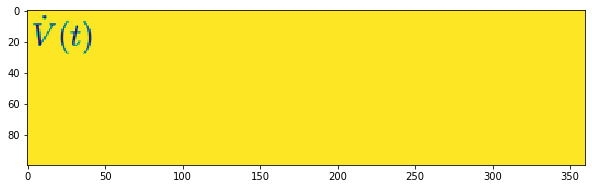

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/176027.png


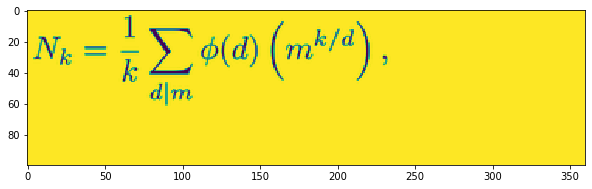

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/d51bb81d3e.png


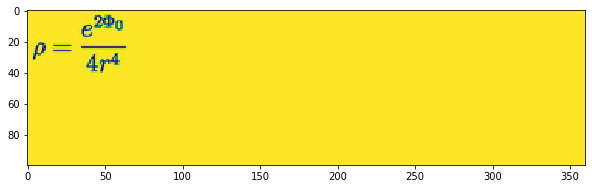

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/67517.png


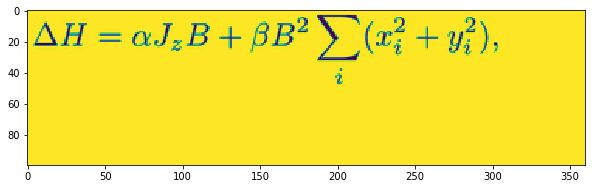

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/209590.png


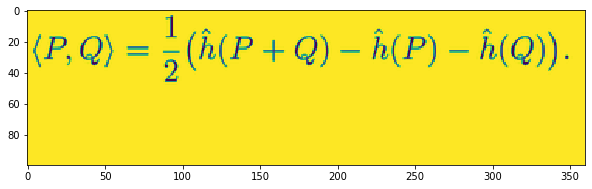

In [12]:
def show_formula(idx):
    formula = read_image(train_images[idx])
    print(train_images[idx])
#     pair = np.concatenate((formula), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(formula)
    plt.show()
    
for idx in range(5):
    show_formula(idx)

In [13]:
# formula_avg = np.array([test[0].T for i, formula in enumerate(train)]).mean(axis=0)
# plt.imshow(formula_avg)
# plt.title('Your Average formula')

In [14]:
x_train = np.reshape(train, (len(train), ROWS, COLS, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(test, (len(test), ROWS, COLS, 1))

x_all = np.reshape(all, (len(all), ROWS, COLS, 1))

print("Train shape: {}".format(x_train.shape))
print("Test shape: {}".format(x_test.shape))
print("All shape: {}".format(all.shape))
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_all = x_all.astype('float32') / 255.

Train shape: (242231, 360, 100, 1)
Test shape: (26914, 360, 100, 1)
All shape: (269145, 1, 360, 100)


In [15]:
autoencoder = None


In [16]:
autoencoder = None
input_img = Input(shape=(ROWS, COLS,1))  
# input_img_padding = ZeroPadding2D((0,0))(input_img)  #zero padding image to shape 124, 52

# Block 1
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)


x = Flatten()(x)
# x = Dense(20608, activation='relu', name='efc0')(x)
x = Dense(4096, activation='relu', name='efc1')(x)
# x = Dense(2048, activation='relu', name='efc2')(x)
x = Dense(1024, activation='relu', name='efc3')(x)
x = Dense(512, activation='relu', name='efc4')(x)
encoded = x

x = Dense(1024, activation='relu', name='dfc1')(encoded)
# x = Dense(2048, activation='relu', name='dfc2')(x)
x = Dense(4096, activation='relu', name='dfc3')(x)
x = Dense(20608, activation='relu', name='dfc4')(x)
x = Reshape((23, 7, 128))(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Cropping2D((2,2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
decoded = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
decoded_cropping = Cropping2D((0,2))(decoded)


autoencoder = Model(input_img, decoded_cropping)

autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
'''
# parallel_model = multi_gpu_model(autoencoder, gpus=2)
# 

# parallel_model.compile(optimizer='adadelta', loss='binary_crossentropy')
'''

autoencoder.summary()

W0923 15:15:16.194222 139870852372288 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0923 15:15:16.219393 139870852372288 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 15:15:16.224603 139870852372288 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 15:15:16.250351 139870852372288 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 360, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 360, 100, 16)      160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 360, 100, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 180, 50, 16)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 50, 32)       4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 50, 32)       9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 25, 32)        0         
__________

In [17]:
from keras.utils import plot_model
plot_model(autoencoder, to_file='model.png')


In [21]:

# x_train = np.reshape(x_train, (len(x_train), 360, 60, 1))  # adapt this if using `channels_first` image data format
# x_test = np.reshape(x_test, (len(x_test), 360, 60, 1))  # adapt this if using `channels_first` image data format

In [22]:
# autoencoder.compile(loss='mean_squared_error', optimizer='adadelta', metrics=['accuracy'])
# checkpoint = ModelCheckpoint("8_8_16_360x60_demo.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
# early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')


In [23]:
from keras.utils import multi_gpu_model
G = 4
model = multi_gpu_model(autoencoder, gpus=G)
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

W0923 15:03:19.774209 140141706053440 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0923 15:03:19.776262 140141706053440 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0923 15:03:28.446388 140141706053440 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0923 15:03:28.462796 140141706053440 deprecation.py:323] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.op

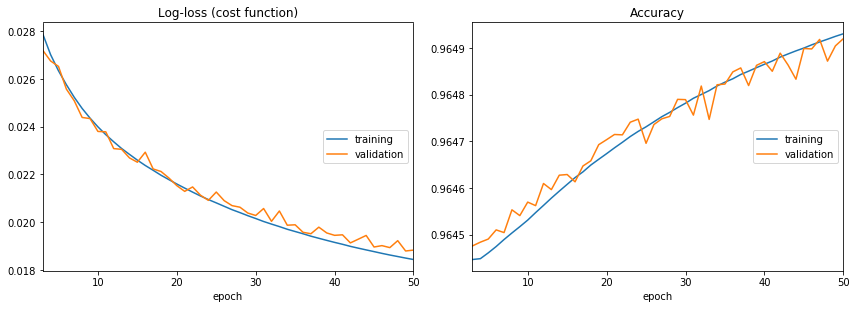

Log-loss (cost function):
training   (min:    0.018, max:    0.039, cur:    0.018)
validation (min:    0.019, max:    0.030, cur:    0.019)

Accuracy:
training   (min:    0.964, max:    0.965, cur:    0.965)
validation (min:    0.964, max:    0.965, cur:    0.965)




In [18]:
print(datetime.now())
from livelossplot.keras import PlotLossesCallback
plot_losses = PlotLossesCallback()

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test),
                callbacks=[plot_losses,TensorBoard(log_dir='/data/szr207/dataset/autoencoder/15:10:22')#+str(now.strftime("%H:%M:%S")))
                           ,TQDMNotebookCallback(leave_inner=True,leave_outer=True)])


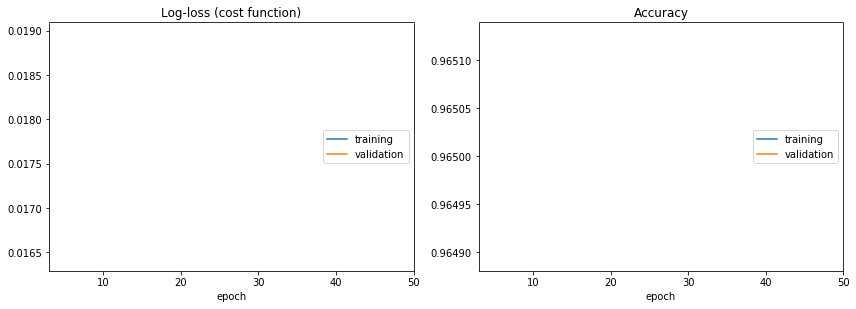

Log-loss (cost function):
training   (min:    0.016, max:    0.018, cur:    0.016)
validation (min:    0.017, max:    0.019, cur:    0.017)

Accuracy:
training   (min:    0.965, max:    0.965, cur:    0.965)
validation (min:    0.965, max:    0.965, cur:    0.965)




In [21]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test),
                callbacks=[plot_losses,TensorBoard(log_dir='/data/szr207/dataset/autoencoder/15:10:22')#+str(now.strftime("%H:%M:%S")))
                           ,TQDMNotebookCallback(leave_inner=True,leave_outer=True)])


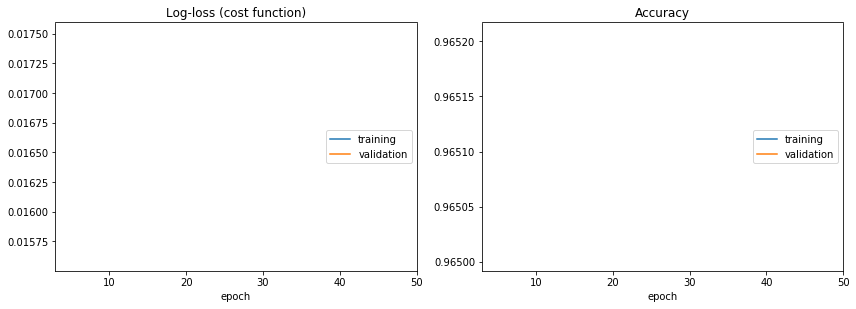

Log-loss (cost function):
training   (min:    0.016, max:    0.016, cur:    0.016)
validation (min:    0.017, max:    0.018, cur:    0.017)

Accuracy:
training   (min:    0.965, max:    0.965, cur:    0.965)
validation (min:    0.965, max:    0.965, cur:    0.965)



KeyboardInterrupt: 

In [22]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=64,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test),
                callbacks=[plot_losses,TensorBoard(log_dir='/data/szr207/dataset/autoencoder/15:10:22')#+str(now.strftime("%H:%M:%S")))
                           ,TQDMNotebookCallback(leave_inner=True,leave_outer=True)])

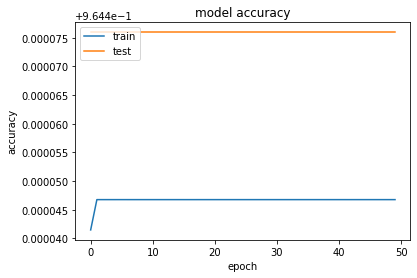

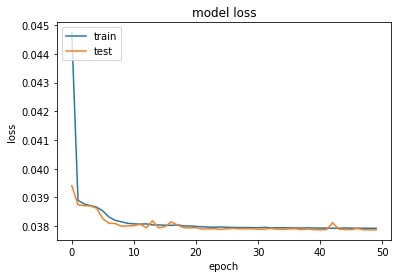

In [21]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
encoder = Model(inputs = input_img, outputs = encoded)

decoded_imgs = autoencoder.predict(x_test)
# encoded_imgs = encoder.predict(x_test)

# all_encoded_imgs = encoder.predict(x_all)

In [25]:
all_decoded_imgs = autoencoder.predict(x_all)

KeyboardInterrupt: 

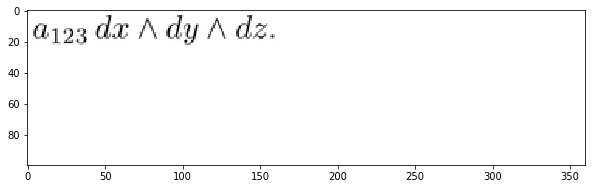

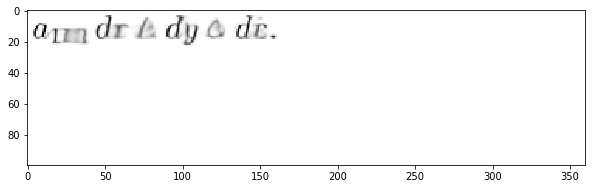

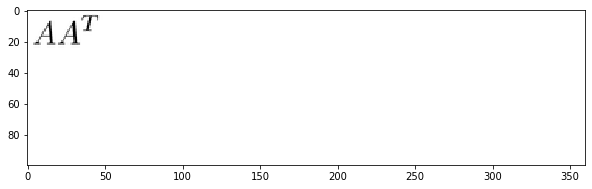

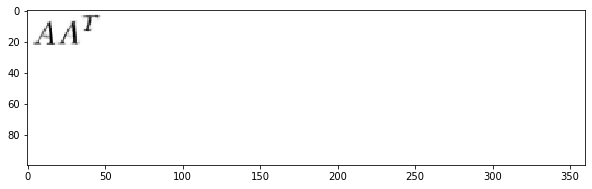

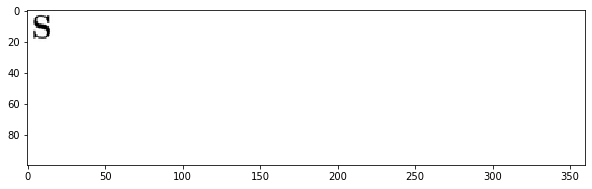

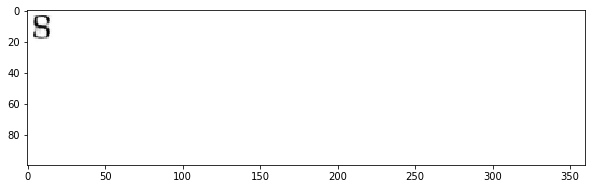

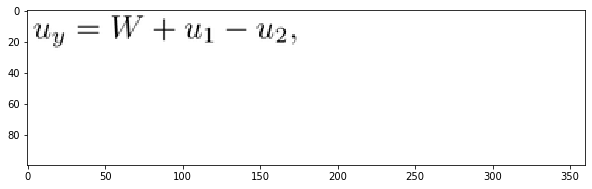

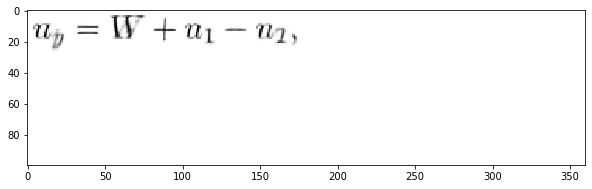

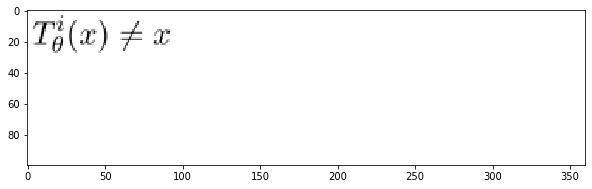

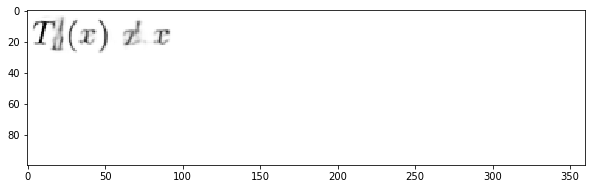

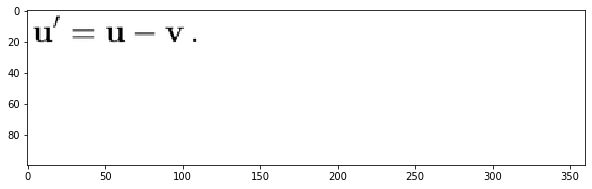

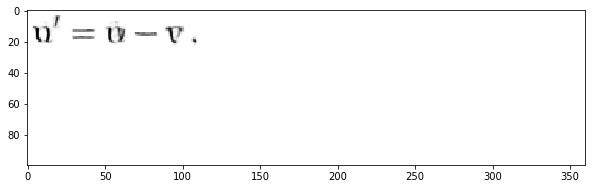

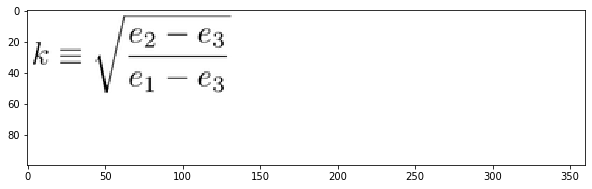

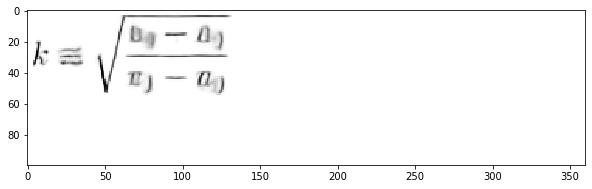

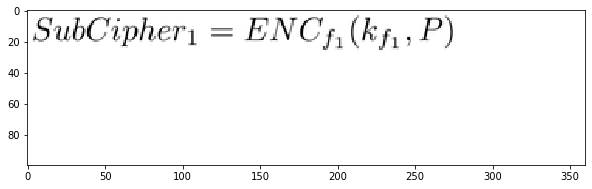

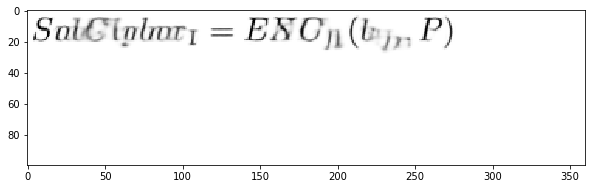

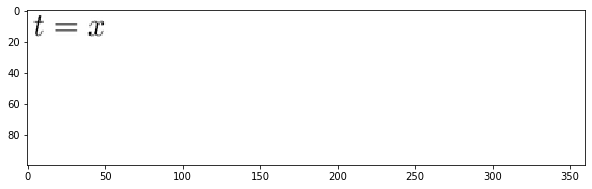

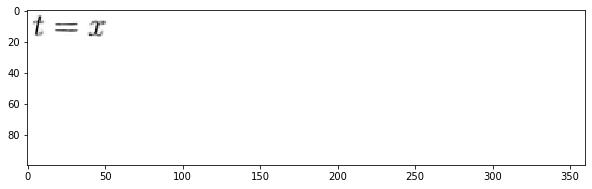

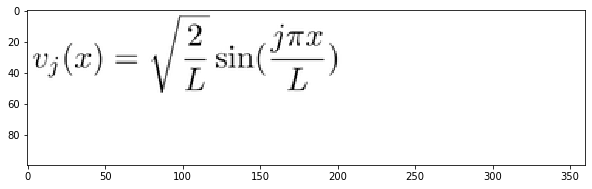

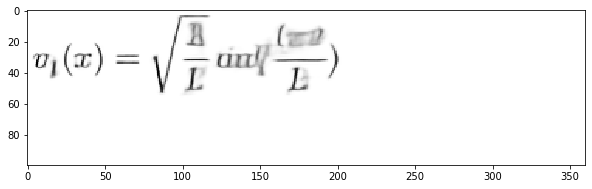

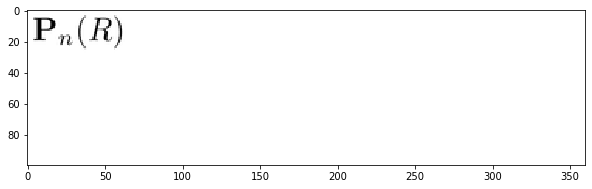

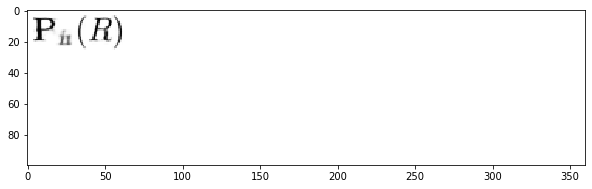

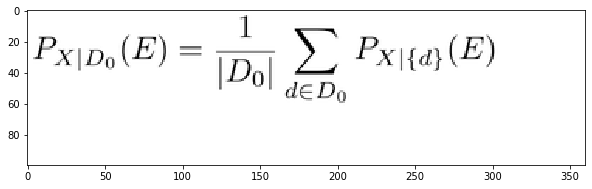

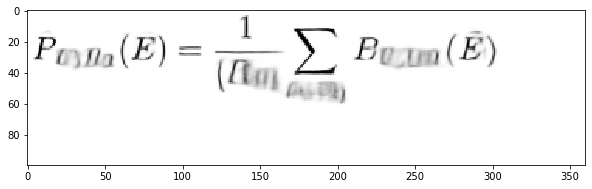

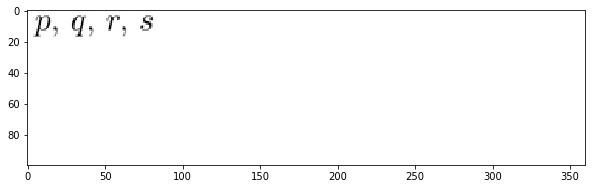

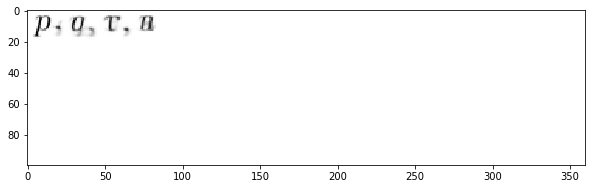

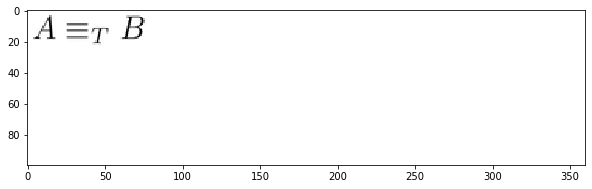

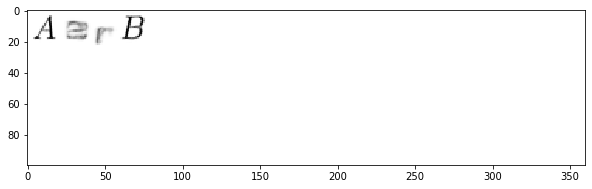

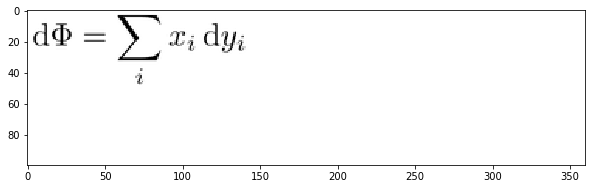

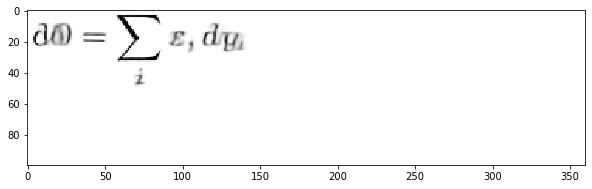

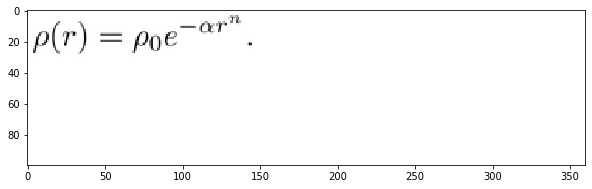

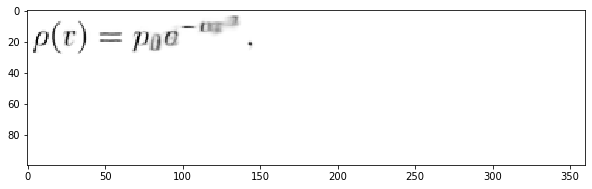

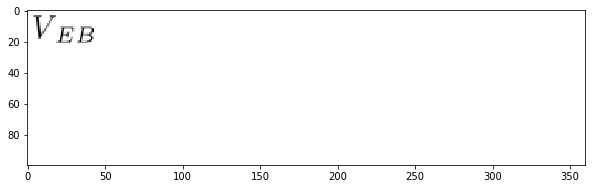

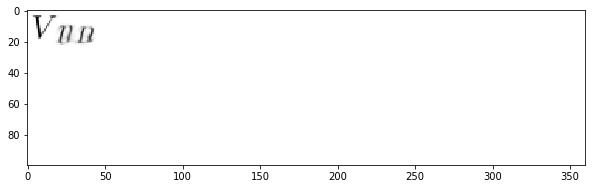

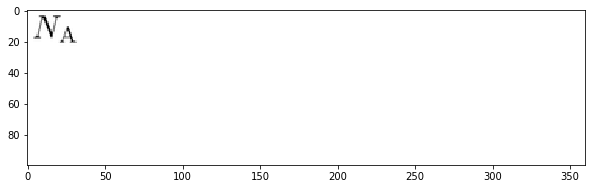

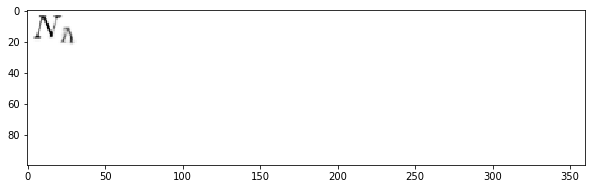

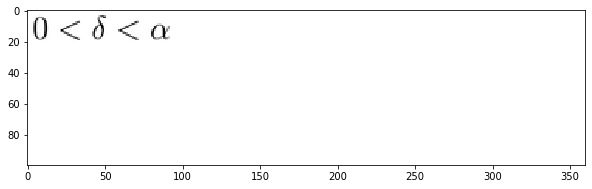

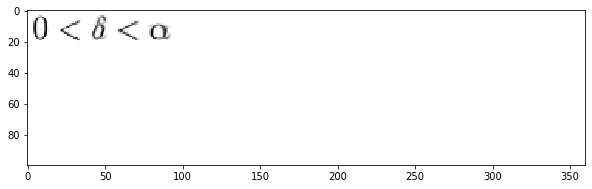

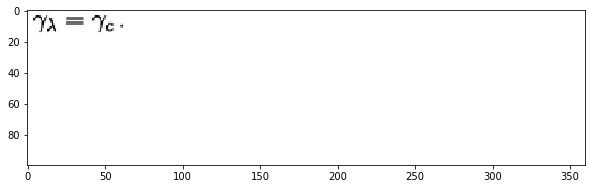

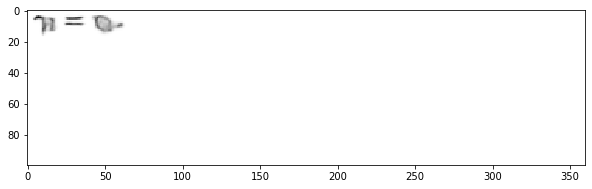

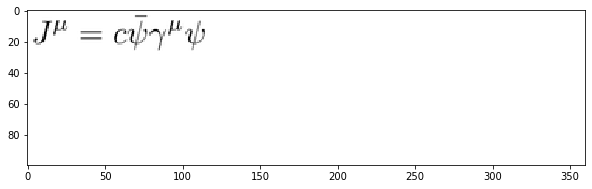

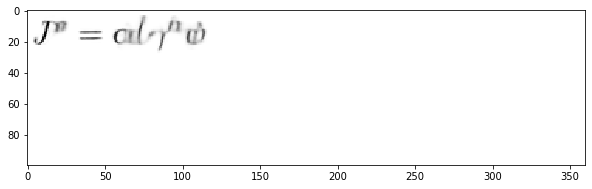

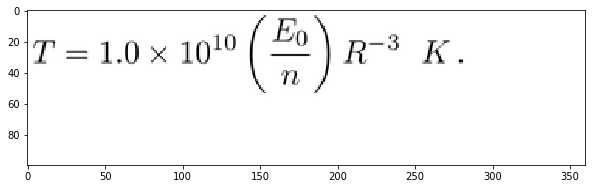

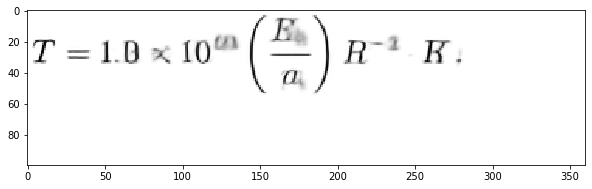

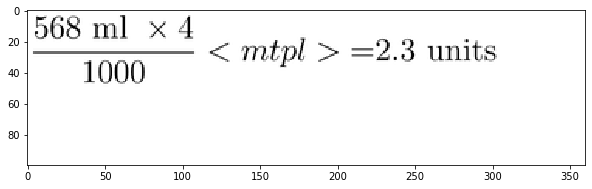

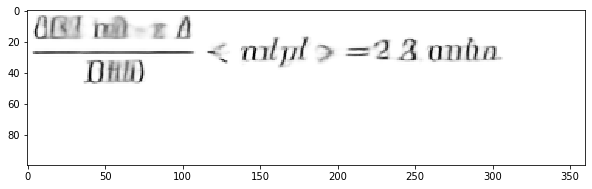

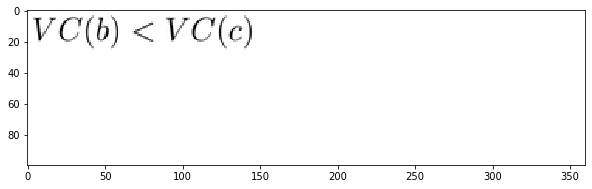

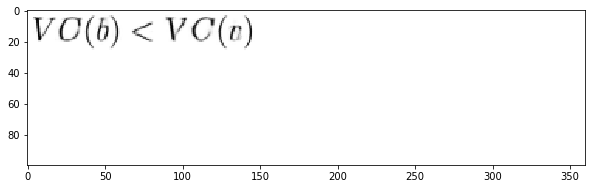

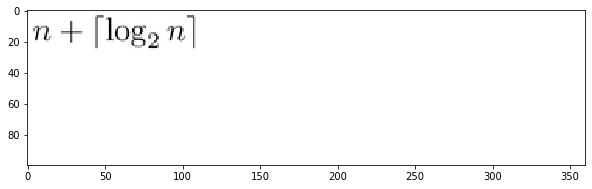

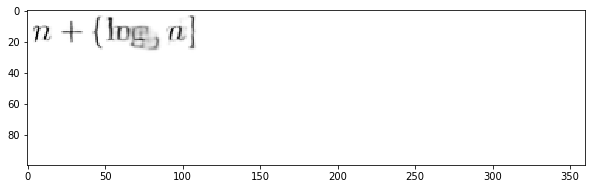

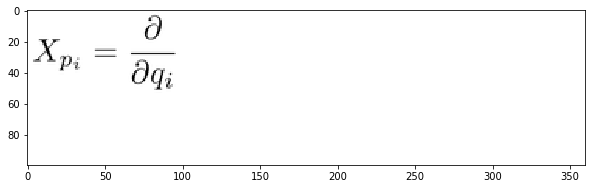

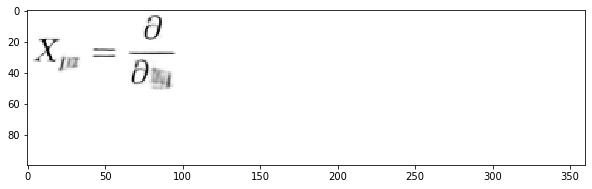

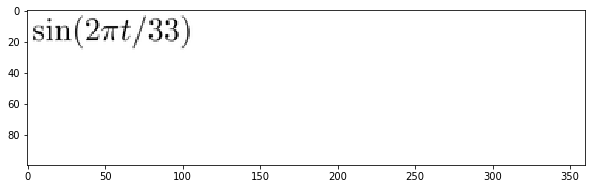

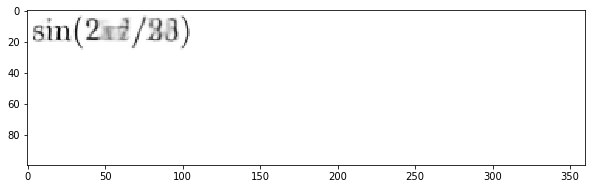

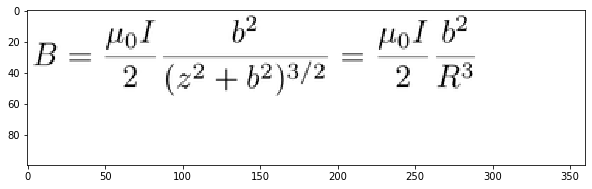

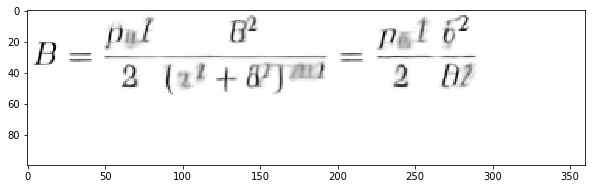

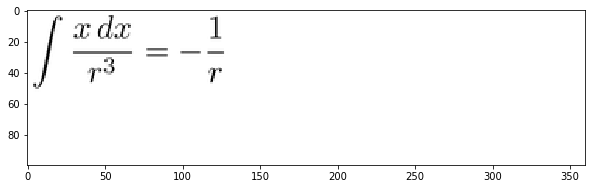

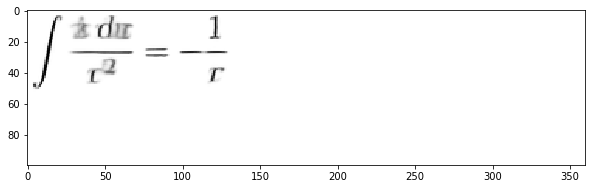

In [24]:

n = 30

for i in range(1,n):
    # display original
    plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(x_test[i]).reshape(COLS, ROWS))
    plt.gray()
    plt.show()
    
#     plt.figure(figsize=(10,5))
#     plt.imshow(np.transpose(encoded_imgs[i]).reshape(6, 3*8))
#     plt.gray()
#     plt.show()
    
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)

    # display reconstruction
    plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(decoded_imgs[i]).reshape(COLS, ROWS))
    plt.gray()
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
    plt.show()

In [26]:
# encoded_imgs_train = encoder.predict(x_train)
# encoded_imgs_test = encoded_imgs
# all_encoded_imgs = encoder.predict(x_all)

# print(encoded_imgs_train.shape)
# print(encoded_imgs_test.shape)
all_encoded_imgs = encoder.predict(x_all)
print(all_encoded_imgs.shape)

(269145, 512)


In [28]:
N = all_encoded_imgs.reshape(len(x_all), 46*13*8)
N.shape

(269145, 512)

In [27]:
encoder.save("encoder_360x100_512.h5")

In [93]:
# from keras.models import load_model

# # load model
# model = load_model('encoder_360x60.h5')

/data/szr207/miniconda/envs/tensorflow_gpuenv/lib/python3.7/site-packages/keras/engine/saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



In [223]:
from sklearn.neighbors import NearestNeighbors

n_neighbors = 1000

model = NearestNeighbors(n_neighbors=n_neighbors, algorithm="brute", metric="cosine")
model.fit(N)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=1000, p=2,
                 radius=1.0)

In [52]:
from joblib import dump, load
dump(model, '360x100_NN_2.joblib') 

['360x100_NN_2.joblib']

[[0.        4.459362  4.781575  5.1977487 5.485129  6.1258993]]
/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/308859.png


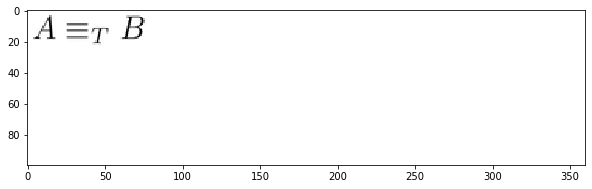

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/261807.png


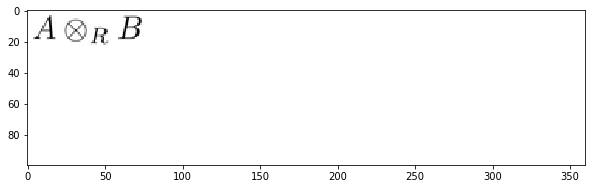

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/235346.png


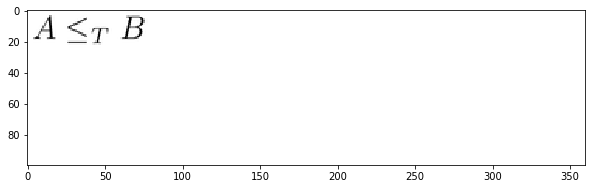

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/255446.png


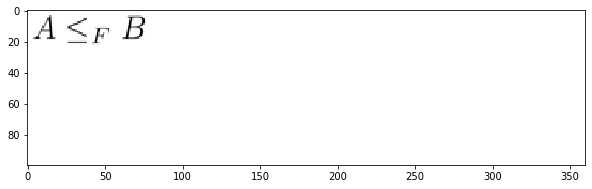

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/248712.png


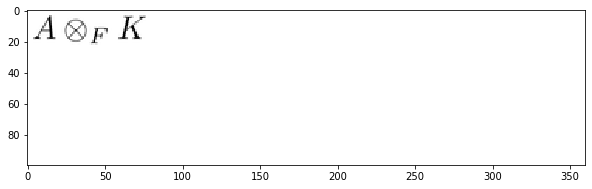

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/114950.png


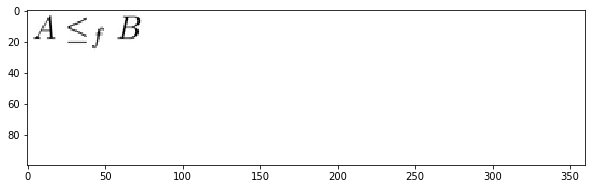

In [213]:
distance, idx = model.kneighbors(N[14].reshape(1, -1) ,return_distance=True ,n_neighbors=6 )
# q_ROWS = 
# q_COLS = 
print(distance)
def show_formula(idx):
    formula = read_image(all_images[idx])
    print(all_images[idx])
#     plt.imshow(np.transpose(decoded_imgs[i]).reshape(COLS, ROWS))

#     pair = np.concatenate((formula), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(formula)
    plt.show()
    
#     plt.figure(figsize=(10,5))
#     plt.imshow(np.transpose(all_decoded_imgs[idx]).reshape(COLS, ROWS))
#     plt.show()
    
for i in idx[0]:
    show_formula(i)

[[    15 170970 230938 150242 184822  32199]]
/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/300802.png


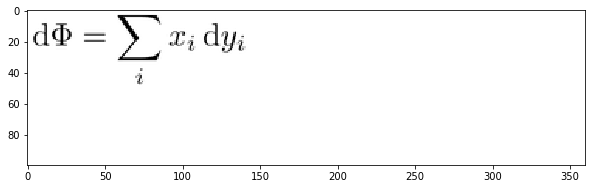

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/69396.png


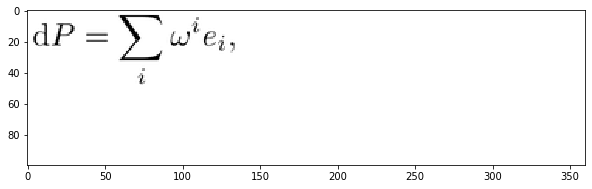

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/252291.png


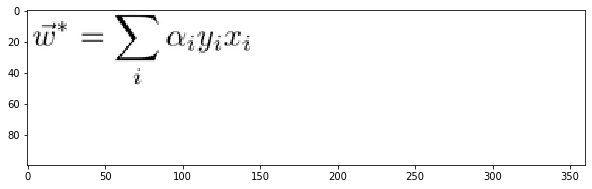

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/217401.png


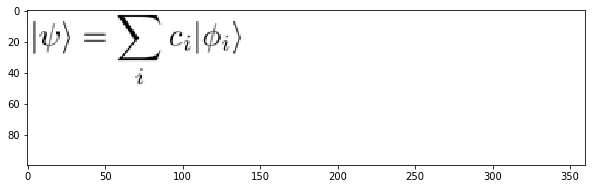

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/69398.png


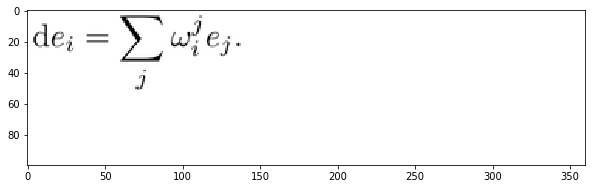

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/318979.png


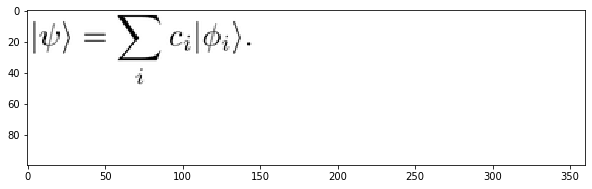

In [128]:
distance, idx = model.kneighbors(N[15].reshape(1, -1) ,return_distance=True ,n_neighbors=6 )
# q_ROWS = 
# q_COLS = 
print(idx)
def show_formula(idx):
    formula = read_image(all_images[idx])
    print(all_images[idx])
#     plt.imshow(np.transpose(decoded_imgs[i]).reshape(COLS, ROWS))

#     pair = np.concatenate((formula), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(formula)
    plt.show()
    
#     plt.figure(figsize=(10,5))
#     plt.imshow(np.transpose(all_decoded_imgs[idx]).reshape(COLS, ROWS))
#     plt.show()
    
for i in idx[0]:
    show_formula(i)

[[    16 269018 241904 136917 111152  50714]]
/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/69631.png


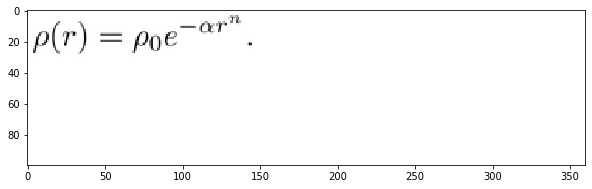

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/234892.png


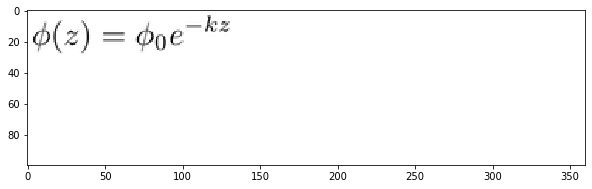

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/304198.png


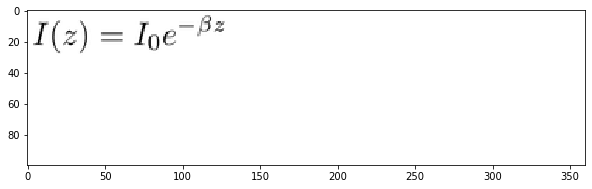

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/126351.png


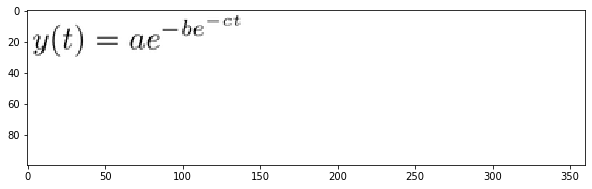

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/91692.png


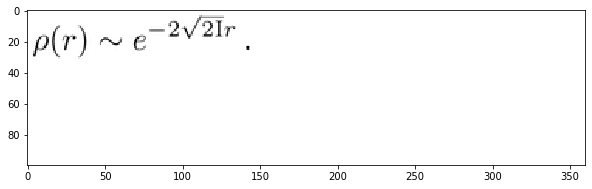

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/243658.png


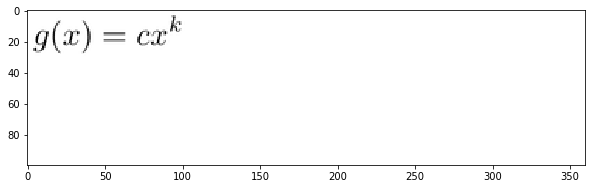

In [129]:
distance, idx = model.kneighbors(N[16].reshape(1, -1) ,return_distance=True ,n_neighbors=6 )
# q_ROWS = 
# q_COLS = 
print(idx)
def show_formula(idx):
    formula = read_image(all_images[idx])
    print(all_images[idx])
#     plt.imshow(np.transpose(decoded_imgs[i]).reshape(COLS, ROWS))

#     pair = np.concatenate((formula), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(formula)
    plt.show()
    
#     plt.figure(figsize=(10,5))
#     plt.imshow(np.transpose(all_decoded_imgs[idx]).reshape(COLS, ROWS))
#     plt.show()
    
for i in idx[0]:
    show_formula(i)

[[    29 146777  93598  31609 101740 144285]]
/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/177856.png


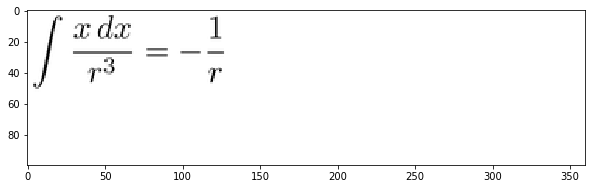

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/177869.png


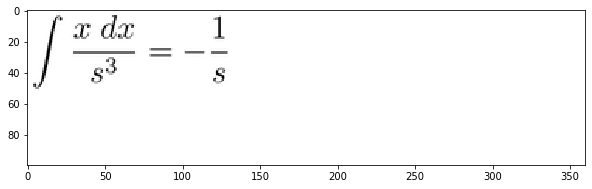

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/177871.png


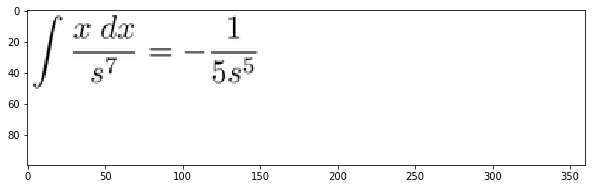

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/177870.png


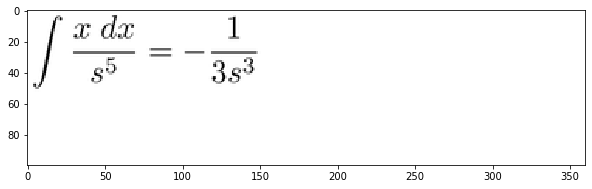

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/177855.png


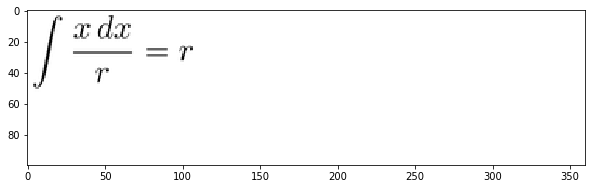

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/177868.png


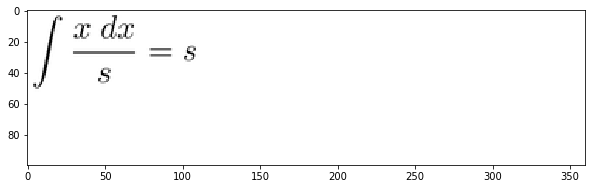

In [142]:
distance, idx = model.kneighbors(N[29].reshape(1, -1) ,return_distance=True ,n_neighbors=6 )
# q_ROWS = 
# q_COLS = 
print(idx)
def show_formula(idx):
    formula = read_image(all_images[idx])
    print(all_images[idx])
#     plt.imshow(np.transpose(decoded_imgs[i]).reshape(COLS, ROWS))

#     pair = np.concatenate((formula), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(formula)
    plt.show()
    
#     plt.figure(figsize=(10,5))
#     plt.imshow(np.transpose(all_decoded_imgs[idx]).reshape(COLS, ROWS))
#     plt.show()
    
for i in idx[0]:
    show_formula(i)

[[    33 192314 136079 154622 234648 128241]]
/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/250683.png


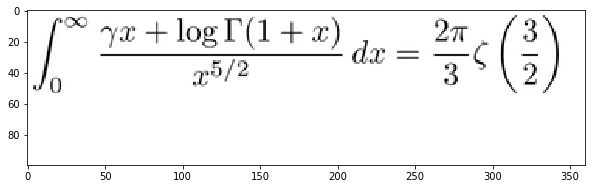

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/176601.png


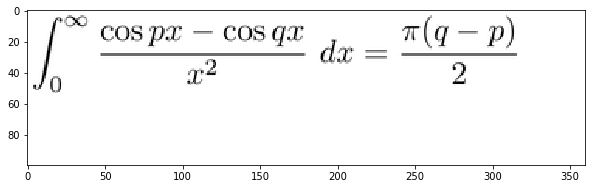

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/176600.png


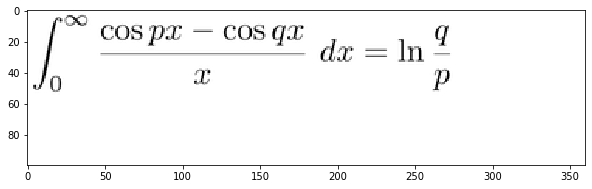

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/275656.png


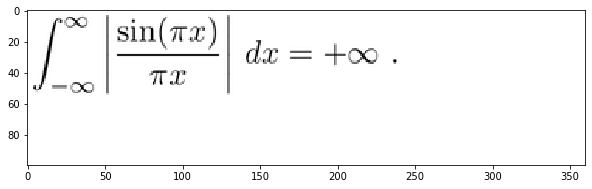

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/176624.png


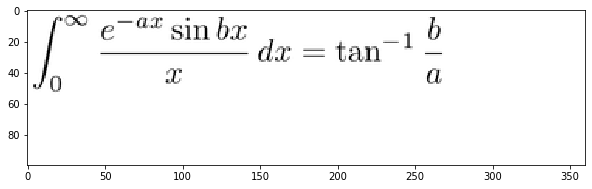

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/176642.png


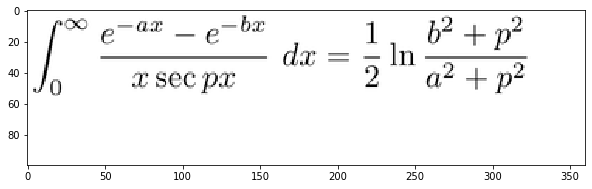

In [147]:
distance, idx = model.kneighbors(N[33].reshape(1, -1) ,return_distance=True ,n_neighbors=6 )
# q_ROWS = 
# q_COLS = 
print(idx)
def show_formula(idx):
    formula = read_image(all_images[idx])
    print(all_images[idx])
#     plt.imshow(np.transpose(decoded_imgs[i]).reshape(COLS, ROWS))

#     pair = np.concatenate((formula), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(formula)
    plt.show()
    
#     plt.figure(figsize=(10,5))
#     plt.imshow(np.transpose(all_decoded_imgs[idx]).reshape(COLS, ROWS))
#     plt.show()
    
for i in idx[0]:
    show_formula(i)

[[1.7881393e-07 4.0013433e-02 5.8702230e-02 6.4648509e-02 6.9059074e-02
  7.5274169e-02]]
/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/237998.png


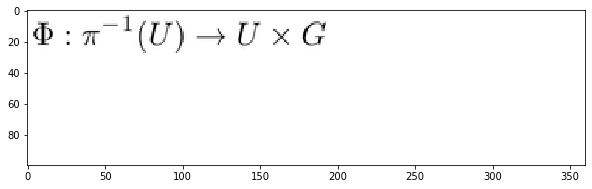

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/20153.png


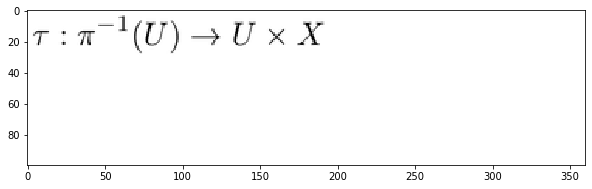

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/50496.png


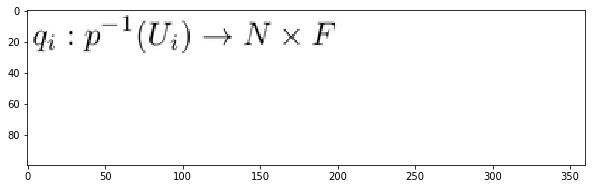

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/296979.png


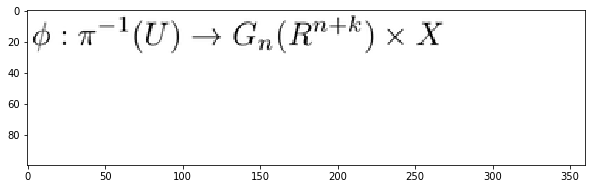

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/113156.png


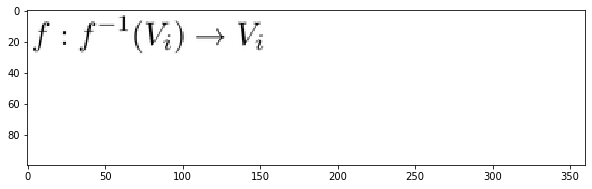

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/320100.png


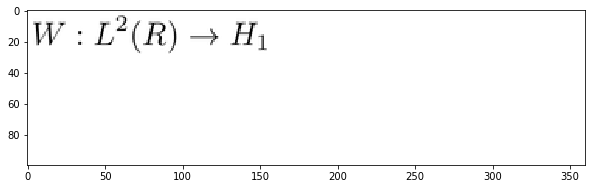

In [177]:
distance, idx = model.kneighbors(N[618].reshape(1, -1) ,return_distance=True ,n_neighbors=6 )
# q_ROWS = 
# q_COLS = 
print(distance)
def show_formula(idx):
    formula = read_image(all_images[idx])
    print(all_images[idx])
#     plt.imshow(np.transpose(decoded_imgs[i]).reshape(COLS, ROWS))

#     pair = np.concatenate((formula), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(formula)
    plt.show()
    
#     plt.figure(figsize=(10,5))
#     plt.imshow(np.transpose(all_decoded_imgs[idx]).reshape(COLS, ROWS))
#     plt.show()
    
for i in idx[0]:
    show_formula(i)

# Query NTCIR 

In [31]:
query_image = '/data/szr207/dataset/ntcir/query_images_forced/360_100/'
query_images = [query_image+i for i in tqdm(os.listdir(query_image))] # use this for full dataset


In [32]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) 
    #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS))


#interpolation=cv2.INTER_CUBIC


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    for i, image_file in tqdm(enumerate(images)):
        image = read_image(image_file)
        data[i] = image.T    
    return data

queries = prep_data(query_images)

In [82]:
query_images

['/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-2.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-17.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-8.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-18.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-1.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-12.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-11.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-13.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-9.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-7.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-5.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-10.png',
 '/data/sz

In [83]:
encode_queries.shape

(14, 512)

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-2.png


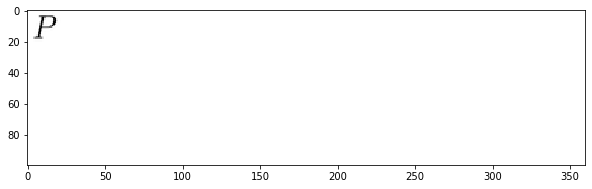

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-17.png


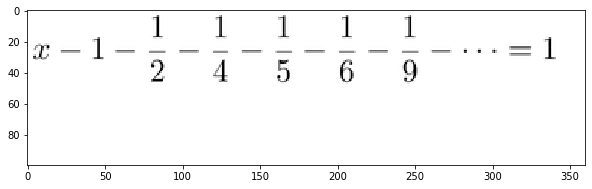

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-8.png


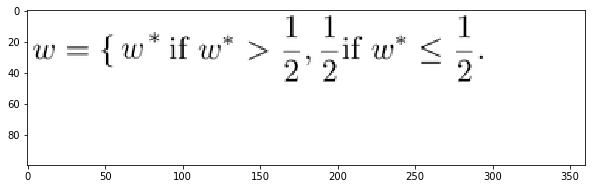

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-18.png


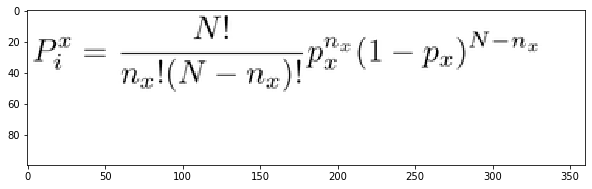

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-1.png


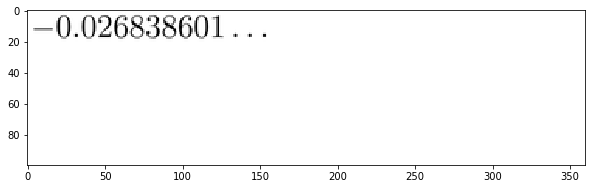

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-12.png


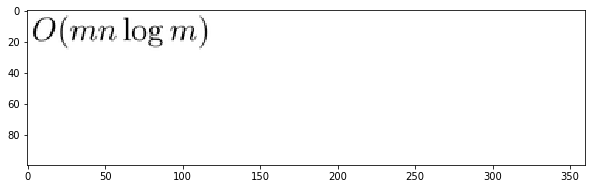

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-11.png


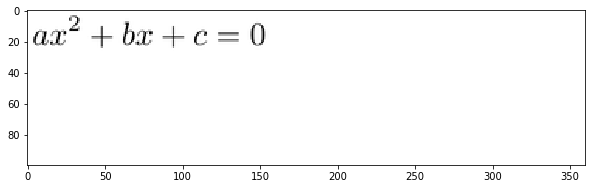

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-13.png


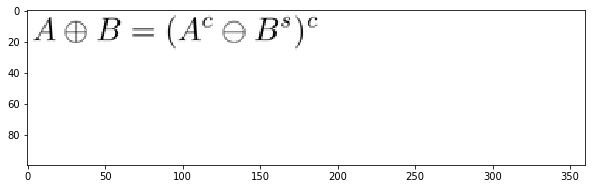

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-9.png


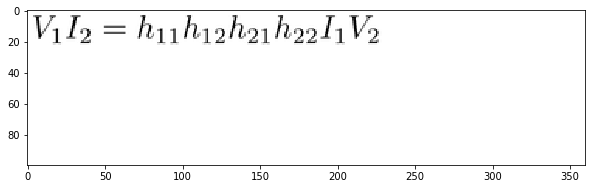

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-7.png


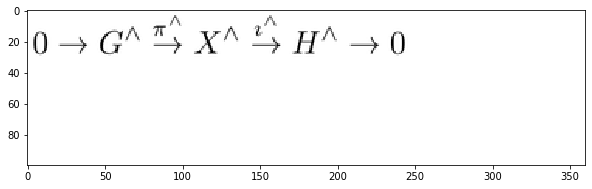

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-5.png


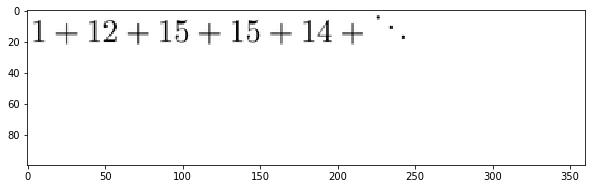

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-10.png


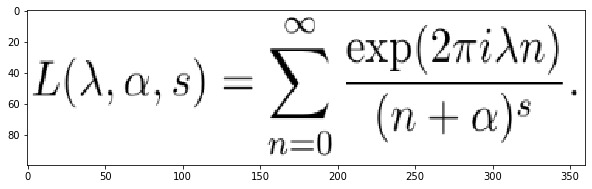

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-16.png


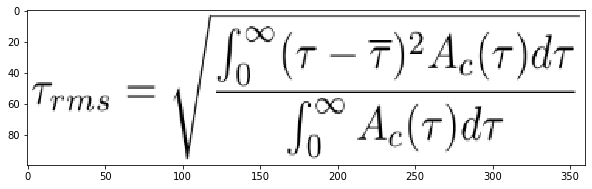

/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-4.png


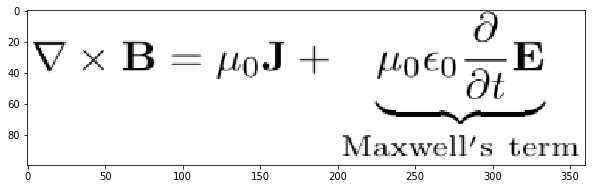

In [33]:
def show_formula(idx):
    formula = read_image(query_images[idx])
    print(query_images[idx])
#     pair = np.concatenate((formula), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(formula)
    plt.show()
    
for idx in range(0,len(query_images)):
    show_formula(idx)

In [34]:
x_query = np.reshape(queries, (len(queries), ROWS, COLS, 1))  # adapt this if using `channels_first` image data format
x_query = x_query.astype('float32') / 255.

In [35]:
encode_queries = encoder.predict(x_query)


In [36]:
len(encode_queries)

14

In [240]:
distance, idx = model.kneighbors(encode_queries[0].reshape(1, -1) ,return_distance=True ,n_neighbors=20 )
print(1-distance)
print(idx)

[[0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
  0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
  0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
  0.99999994 0.99999994]]
[[ 18533  50143  83181  55740 106012   7315 135433  47675 109778   5855
  244145 168135 150053  16914  99541  60926  17643 237443   4017   8196]]


In [241]:
all_images[18533]

'/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/184199.png'

In [243]:
N[18533]

array([0.00000000e+00, 2.37131953e-01, 5.01845598e-01, 0.00000000e+00,
       4.38744202e-04, 0.00000000e+00, 0.00000000e+00, 6.88050091e-01,
       7.20302284e-01, 7.20778346e-01, 4.34191525e-02, 1.24559551e-01,
       2.77276814e-01, 0.00000000e+00, 5.51718056e-01, 0.00000000e+00,
       7.61668980e-01, 2.84142792e-01, 6.09842002e-01, 1.21021020e+00,
       6.87603056e-01, 8.60483423e-02, 2.57781446e-01, 6.16260052e-01,
       5.17234981e-01, 3.02128911e-01, 1.01006866e+00, 7.59054005e-01,
       4.64382827e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.52239096e-01, 2.88716741e-02, 5.00476062e-01, 0.00000000e+00,
       4.87576038e-01, 5.67163587e-01, 6.79304957e-01, 7.72604272e-02,
       4.51125056e-01, 1.14060640e+00, 6.99720383e-01, 0.00000000e+00,
       0.00000000e+00, 1.02252173e+00, 1.41134226e+00, 2.45651081e-01,
       8.86917353e-01, 1.25122702e+00, 7.86765158e-01, 0.00000000e+00,
       0.00000000e+00, 5.26448667e-01, 0.00000000e+00, 0.00000000e+00,
      

In [255]:
d2.item().get("Lozenge:0") 

array([0.00000000e+00, 2.37131953e-01, 5.01845598e-01, 0.00000000e+00,
       4.38744202e-04, 0.00000000e+00, 0.00000000e+00, 6.88050091e-01,
       7.20302284e-01, 7.20778346e-01, 4.34191525e-02, 1.24559551e-01,
       2.77276814e-01, 0.00000000e+00, 5.51718056e-01, 0.00000000e+00,
       7.61668980e-01, 2.84142792e-01, 6.09842002e-01, 1.21021020e+00,
       6.87603056e-01, 8.60483423e-02, 2.57781446e-01, 6.16260052e-01,
       5.17234981e-01, 3.02128911e-01, 1.01006866e+00, 7.59054005e-01,
       4.64382827e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       4.52239096e-01, 2.88716741e-02, 5.00476062e-01, 0.00000000e+00,
       4.87576038e-01, 5.67163587e-01, 6.79304957e-01, 7.72604272e-02,
       4.51125056e-01, 1.14060640e+00, 6.99720383e-01, 0.00000000e+00,
       0.00000000e+00, 1.02252173e+00, 1.41134226e+00, 2.45651081e-01,
       8.86917353e-01, 1.25122702e+00, 7.86765158e-01, 0.00000000e+00,
       0.00000000e+00, 5.26448667e-01, 0.00000000e+00, 0.00000000e+00,
      

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/102027.png


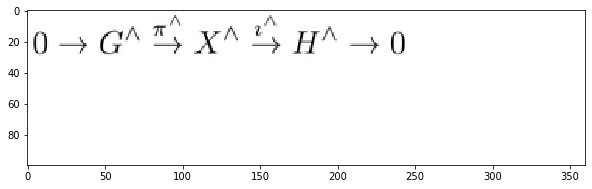

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/273227.png


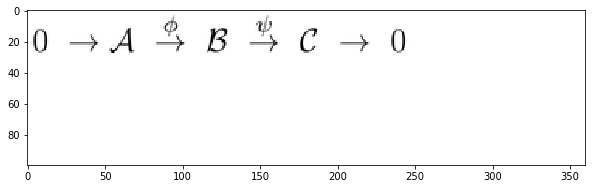

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/325344.png


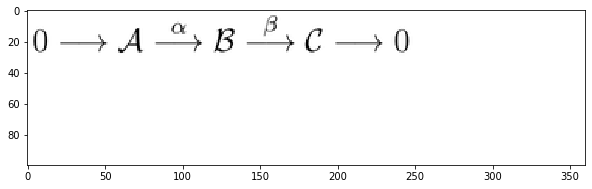

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/72466.png


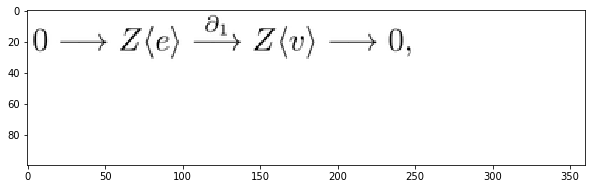

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/62552.png


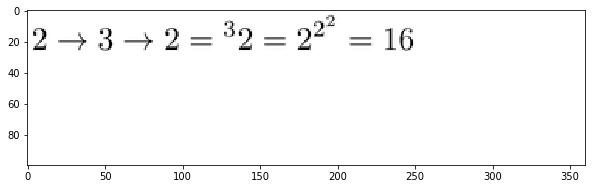

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/80072.png


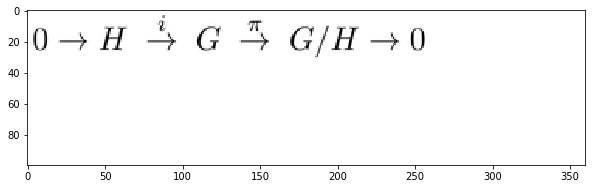

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/102030.png


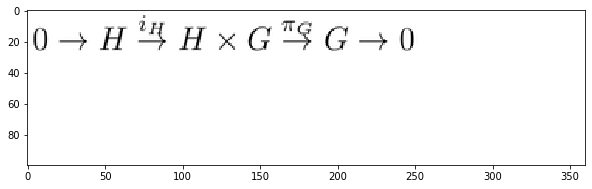

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/303214.png


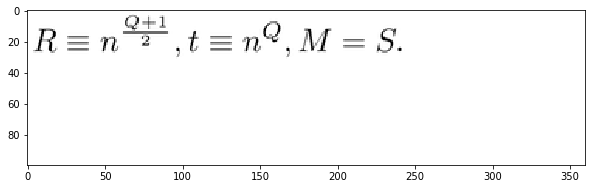

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/249215.png


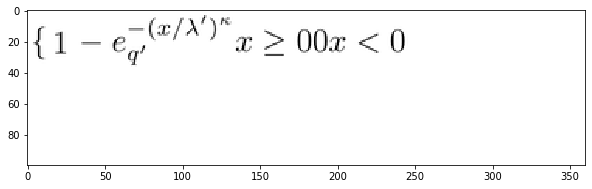

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/195084.png


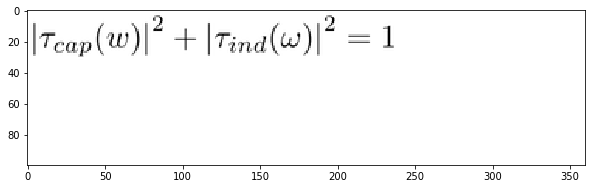

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/100dbfc451.png


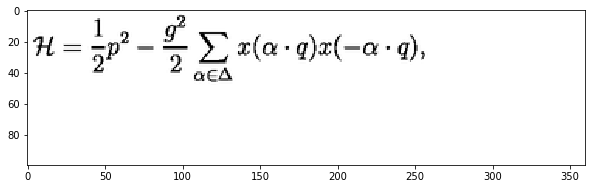

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/262792.png


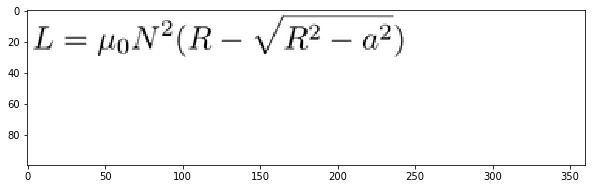

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/227563.png


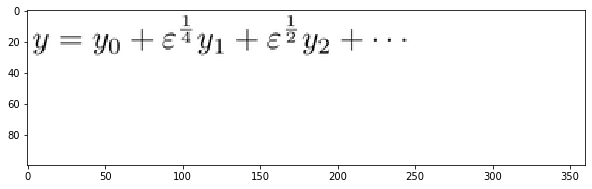

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/99499.png


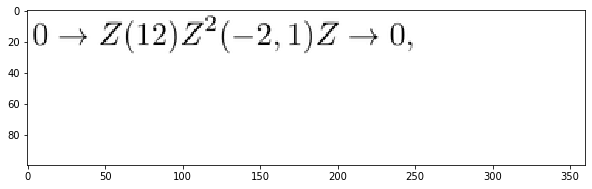

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/172043.png


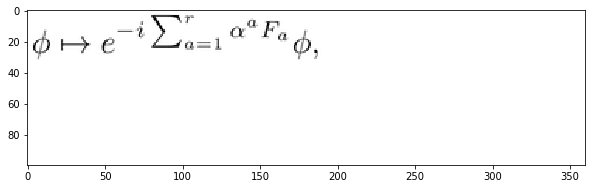

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/54812.png


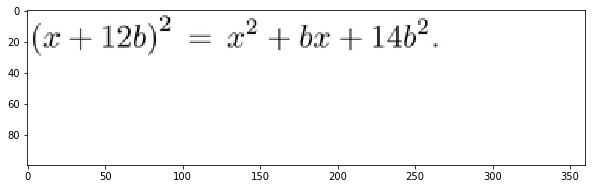

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/220941.png


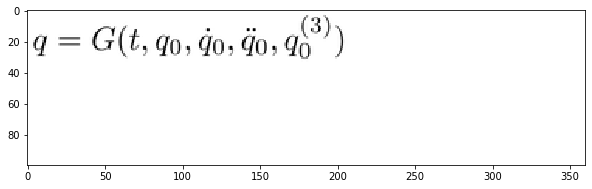

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/7c3cee0b54.png


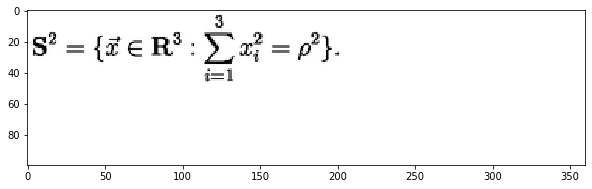

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/322856.png


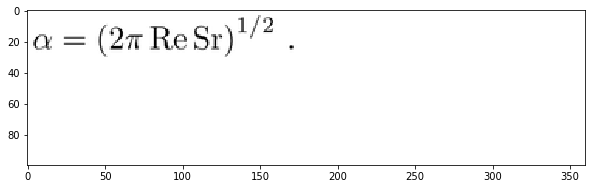

/data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/12090.png


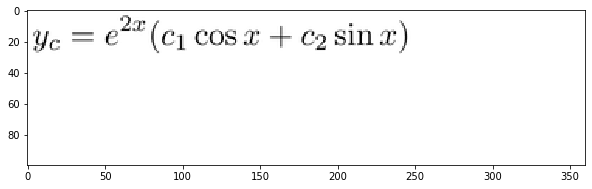

In [56]:
def show_formula(idx):
    formula = read_image(all_images[idx])
    print(all_images[idx])
#     plt.imshow(np.transpose(decoded_imgs[i]).reshape(COLS, ROWS))

#     pair = np.concatenate((formula), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(formula)
    plt.show()
    
#     plt.figure(figsize=(10,5))
#     plt.imshow(np.transpose(all_decoded_imgs[idx]).reshape(COLS, ROWS))
#     plt.show()
    
for i in idx[0]:
    show_formula(i)

In [242]:
N[0]

array([0.        , 0.9254555 , 3.1815836 , 0.        , 3.433364  ,
       0.        , 4.534066  , 2.96088   , 3.0277734 , 1.5813755 ,
       2.6880722 , 0.16159216, 1.8011451 , 0.        , 0.92170185,
       0.        , 2.8184505 , 1.5519588 , 2.7165751 , 1.086216  ,
       4.1560926 , 5.0544705 , 1.169029  , 1.527781  , 3.4441135 ,
       2.8122318 , 2.4194398 , 4.244696  , 1.4368507 , 0.        ,
       0.        , 0.        , 3.5796683 , 0.        , 5.3244643 ,
       0.        , 5.0453587 , 2.976556  , 4.933971  , 1.1228178 ,
       2.645958  , 3.31877   , 2.8195121 , 0.        , 0.        ,
       0.4018151 , 3.6232858 , 3.190618  , 1.5464107 , 3.942965  ,
       3.0879822 , 0.        , 1.9230039 , 5.3243847 , 0.        ,
       0.        , 1.4803354 , 6.0239267 , 2.7303739 , 2.7389405 ,
       0.        , 0.46389621, 4.3846326 , 0.        , 4.677453  ,
       3.3585954 , 3.3061326 , 0.        , 1.6408491 , 0.        ,
       2.0739648 , 1.1732664 , 2.411907  , 2.740402  , 0.     

In [57]:
import jsonlines

dict_jl = {}

with jsonlines.open('/data/szr207/dataset/ntcir/output.jsonl') as reader:
    for obj in tqdm(reader):
       dict_jl[obj['id']] = obj['list_id']

In [58]:
dict_jl[2]

['100000000_(number):0']

In [59]:
# get absolute image name and return wiki id 

def get_wiki_id(image_path):
    try:
        return dict_jl[int(image_path)]
    except :
        return None



In [261]:
f = open("encoder_512_cosine.dat", "w")
# f.write("Now the file has more content!")


for query,enc_query in tqdm(zip(query_images,encode_queries)):
    distance, idx = model.kneighbors(enc_query.reshape(1, -1) ,return_distance=True ,n_neighbors=1000 )
    count = 1
    for i,dist in zip(idx[0],distance[0]):
        if get_wiki_id(os.path.basename(all_images[i]).split('.')[0]):
            for j in get_wiki_id(os.path.basename(all_images[i]).split('.')[0]):
#                 print('NTCIR12-MathWiki-2',j,1.-float(dist))
#                 print(os.path.basename(query).split('.')[0]+'\t'+'1'+'\t'+j+'\t'+str(1.-float(dist))+'\t'+"encoder")
                f.write(os.path.basename(query).split('.')[0]+'\t'+'1'+'\t'+j+ '\t' + str(count) +'\t'+str(1.-float(dist))+'\t'+"encoder"+'\n')
#     break
f.close()

4017 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/118931.png
50143 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/105807.png
109778 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/2703.png
17643 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/203179.png
60926 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/188423.png
5855 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/218798.png
7315 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/72330.png
237443 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/241765.png
106012 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/196622.png
99541 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/302863.png
147949 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/37844.png
236852 /data/szr207/dataset/ntcir/forced_resolution/corrected/360_100/302862.png
150053 /data/szr207/dataset/ntcir/forced_r

In [74]:
path_output_formula = '/data/szr207/dataset/ntcir/output.jsonl'

forced_resolution      pdf_math       query_images_forced     tex_dir_copy
formula_images.tar.gz  pdf_math_copy  query_images_processed  unique_wiki.json
havard_images	       png_math       tangent_v_queries
images_processed       png_math.tar   tangent-v_resolution
output.jsonl	       query_images   tex_dir


In [64]:
h5f = h5py.File("encoder_512_id_paths.h5", 'w')
h5f.create_dataset('names', data = np.string_(all_images))
h5f.create_dataset('embeddings', data = N)
h5f.close()

In [65]:
h5f = h5py.File("encoder_512_id_paths.h5",'r')

In [66]:
paths = h5f['names'][:]
list_embeddings = h5f['embeddings'][:]

In [244]:
import os
list_embeddings[0]

array([0.        , 0.9254555 , 3.1815836 , 0.        , 3.433364  ,
       0.        , 4.534066  , 2.96088   , 3.0277734 , 1.5813755 ,
       2.6880722 , 0.16159216, 1.8011451 , 0.        , 0.92170185,
       0.        , 2.8184505 , 1.5519588 , 2.7165751 , 1.086216  ,
       4.1560926 , 5.0544705 , 1.169029  , 1.527781  , 3.4441135 ,
       2.8122318 , 2.4194398 , 4.244696  , 1.4368507 , 0.        ,
       0.        , 0.        , 3.5796683 , 0.        , 5.3244643 ,
       0.        , 5.0453587 , 2.976556  , 4.933971  , 1.1228178 ,
       2.645958  , 3.31877   , 2.8195121 , 0.        , 0.        ,
       0.4018151 , 3.6232858 , 3.190618  , 1.5464107 , 3.942965  ,
       3.0879822 , 0.        , 1.9230039 , 5.3243847 , 0.        ,
       0.        , 1.4803354 , 6.0239267 , 2.7303739 , 2.7389405 ,
       0.        , 0.46389621, 4.3846326 , 0.        , 4.677453  ,
       3.3585954 , 3.3061326 , 0.        , 1.6408491 , 0.        ,
       2.0739648 , 1.1732664 , 2.411907  , 2.740402  , 0.     

In [246]:
list_id = []
actual_embeddings = []

for i,vec in zip(paths,list_embeddings):
    try :
        list_id.append(int(os.path.basename(i.decode("utf-8")).split('.')[0]))
        actual_embeddings.append(vec)
    except:
        continue

In [247]:
len(list_id)

256745

In [248]:
len(actual_embeddings)

256745

In [249]:
dict_id_embeddings = {}
for idx, embeddings in zip(list_id,actual_embeddings):
    dict_id_embeddings[idx] = embeddings
        

In [250]:
import jsonlines

In [251]:
dict_id_listexp = {}
with jsonlines.open(path_output_formula) as reader:
    for obj in reader:
        dict_id_listexp[obj["id"]] = obj["list_id"]

In [252]:
dict_wikiid_embeddings = {}
for id_image in tqdm(dict_id_listexp.keys()):
    if id_image in dict_id_embeddings.keys():
        for idx in dict_id_listexp[id_image]:
            dict_wikiid_embeddings[idx] = dict_id_embeddings[id_image]

In [77]:
list(dict_id_listexp.keys())[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [78]:
list(dict_id_embeddings.keys())[:10]

[67571, 152328, 141243, 203561, 153418, 48617, 319768, 194145, 131362, 89419]

In [253]:
np.save("wiki_visual_embeddings.npy", dict_wikiid_embeddings)

In [254]:
import numpy as np

d2=np.load("wiki_visual_embeddings.npy",allow_pickle=True)

In [196]:
d2.item().get('∂:0') # pass wikiid inside the get method to get the embeddings

array([0.        , 1.3101187 , 3.7992337 , 0.        , 2.445343  ,
       0.        , 1.1464638 , 0.400806  , 1.7805841 , 3.0575392 ,
       2.0313478 , 2.4886448 , 2.8630662 , 0.        , 1.6749094 ,
       0.        , 3.158615  , 2.361383  , 0.83169186, 0.20723242,
       1.746133  , 2.5433588 , 0.8513617 , 2.7980273 , 2.0718305 ,
       1.3665514 , 1.372854  , 1.5373527 , 0.12248956, 0.        ,
       0.        , 0.        , 1.3725687 , 0.        , 1.7008139 ,
       0.        , 3.201446  , 2.5260603 , 1.4364575 , 0.        ,
       0.22433975, 1.6826752 , 1.513308  , 0.        , 0.        ,
       0.        , 1.0407176 , 1.1814681 , 1.0052379 , 2.7558033 ,
       2.452246  , 0.        , 2.3936799 , 1.9798167 , 0.        ,
       0.        , 1.6677008 , 2.6530113 , 2.0005062 , 0.74164027,
       0.        , 1.1930614 , 1.0729581 , 0.        , 4.009239  ,
       1.467373  , 2.5068467 , 0.        , 2.1868846 , 0.        ,
       2.0965126 , 0.7422062 , 1.6914653 , 2.1940236 , 0.     

In [9]:
from keras.models import model_from_json

json_file  = open('autoencoder_360x100.json','r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("autoencoder_360x100.h5")

W0918 13:12:12.935080 139963259418432 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0918 13:12:12.985833 139963259418432 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0918 13:12:13.013119 139963259418432 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0918 13:12:13.122347 139963259418432 deprecation_wrapper.py:119] From /data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf

In [10]:
input_img = Input(shape=(ROWS, COLS,1))  
encoder = Model(inputs = input_img, outputs = encoded)

NameError: name 'encoded' is not defined

In [11]:
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 360, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 360, 100, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 180, 50, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 50, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 25, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 13, 32)        0         
__________

In [15]:
encoder = Model(input=loaded_model.layers[0].input, 
                  output=loaded_model.layers[12].output)

/data/szr207/conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  


In [16]:
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 360, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 360, 100, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 180, 50, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 50, 64)       36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 25, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 25, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 13, 32)        0         
__________

In [198]:
encode_queries = encoder.predict(x_query)


In [199]:
encode_queries.shape

(14, 512)

In [19]:
encode_queries = encode_queries.reshape(len(encode_queries), 12*5*8)

In [203]:
query_images

['/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-2.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-17.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-8.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-18.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-1.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-12.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-11.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-13.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-9.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-7.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-5.png',
 '/data/szr207/dataset/ntcir/query_images_forced/360_100/NTCIR12-MathWiki-10.png',
 '/data/sz

In [200]:
dict_query = {}
for query, embedding in zip(query_images,encode_queries):
    dict_query[os.path.basename(query).split('.')[0]] = embedding

In [201]:
dict_query.keys()

dict_keys(['NTCIR12-MathWiki-2', 'NTCIR12-MathWiki-17', 'NTCIR12-MathWiki-8', 'NTCIR12-MathWiki-18', 'NTCIR12-MathWiki-1', 'NTCIR12-MathWiki-12', 'NTCIR12-MathWiki-11', 'NTCIR12-MathWiki-13', 'NTCIR12-MathWiki-9', 'NTCIR12-MathWiki-7', 'NTCIR12-MathWiki-5', 'NTCIR12-MathWiki-10', 'NTCIR12-MathWiki-16', 'NTCIR12-MathWiki-4'])

In [202]:
np.save("query_wiki_visual_embeddings.npy", dict_query)

In [56]:
doc_ids = np.array(list(d2.item().keys()))

In [57]:
doc_vec = np.array(list(d2.item().values()))

In [59]:
doc_vec[0]

array([0.        , 1.6072407 , 1.6583552 , 1.065985  , 2.354113  ,
       1.0040946 , 0.70199287, 2.130816  , 1.9300967 , 1.6228309 ,
       3.2769156 , 1.5693619 , 2.6200035 , 0.        , 1.6729598 ,
       3.0564253 , 0.43718752, 0.8383006 , 0.95065635, 1.2526935 ,
       0.6287049 , 0.02575271, 1.8499366 , 1.2447668 , 0.8745982 ,
       0.5275351 , 0.1021649 , 0.17393127, 0.40844223, 0.        ,
       1.6289839 , 0.18681361, 0.37926564, 0.15501332, 0.06379678,
       0.6139374 , 0.00463305, 0.        , 0.78192735, 0.08090399,
       0.        , 1.0905856 , 2.0705352 , 0.9318893 , 1.411541  ,
       1.5711746 , 2.1599114 , 1.8960584 , 0.9556693 , 2.0826526 ,
       3.3639317 , 0.9280063 , 2.4536824 , 0.        , 2.0702481 ,
       2.7106302 , 0.33011556, 0.49392956, 1.238248  , 0.85480714,
       0.8624886 , 0.        , 1.6771023 , 0.9141057 , 0.6248553 ,
       0.35176325, 0.07346703, 0.1506134 , 0.40996438, 0.        ,
       1.521189  , 0.14063571, 0.21454015, 0.        , 0.04726

In [60]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(n_neighbors=100, algorithm="brute", metric="cosine")
model.fit(doc_vec)



NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                 radius=1.0)

In [84]:
for n_query in range(len(query_images)):
    distance, idx = model.kneighbors(encode_queries[n_query].reshape(1, -1) ,return_distance=True ,n_neighbors=100 )
    count = 1
    for i,dist in zip(idx[0],distance[0]):
        print(os.path.basename(query_images[n_query]).split('.')[0],1,doc_ids[i],count,1./dist,'cnn')
        count+=1

NameError: name 'doc_ids' is not defined

In [159]:
from scipy import spatial
d1 = np.load('query_wiki_visual_embeddings.npy',allow_pickle=True)

query_dic = d1.item()

In [268]:
d2=np.load("wiki_visual_embeddings.npy",allow_pickle=True)

query_vec = d1.item().get("NTCIR12-MathWiki-2").reshape(1,-1)

doc_vec = d2.item().get("TLA+:12") #Lozenge:0

result = 1 - spatial.distance.cosine(doc_vec,query_vec)

result

0.9999997615814209